In [5]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# style for 
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 500)
df = pd.read_csv("../data/processed/all_shots_only_selected_features.csv", index_col=0)

PLAYERS =['Kobe Bryant', 'LeBron James', 'Stephen Curry', 'Kevin Durant', 'Dwyane Wade', 
        'Dirk Nowitzki', 'Tim Duncan', "Shaquille O'Neal", "Steve Nash", "Kawhi Leonard", 
        "James Harden", "Jason Kidd", "Allen Iverson", "Chris Webber", "Kevin Garnett", 
        "Paul Pierce", "Giannis Antetokounmpo", "Jimmy Butler", "Russell Westbrook", "Dwight Howard"]

In [6]:
df.columns

Index(['Shot Distance', 'X Location', 'Y Location', 'Season Type',
       'Shot Zone Basic_Backcourt', 'Shot Zone Basic_In The Paint (Non-RA)',
       'Shot Zone Basic_Left Corner 3', 'Shot Zone Basic_Mid-Range',
       'Shot Zone Basic_Restricted Area', 'Shot Zone Basic_Right Corner 3',
       'Shot Zone Area_Back Court(BC)', 'Shot Zone Area_Left Side(L)',
       'Shot Zone Area_Right Side Center(RC)', 'Shot Zone Area_Right Side(R)',
       'Shot Zone Range_8-16 ft.', 'Shot Zone Range_Back Court Shot',
       'Shot Zone Range_Less Than 8 ft.', 'at_home', 'PREVIOUS_OFF_REBOUND',
       'PREVIOUS_DEF_REBOUND', 'dunk_shot', 'PREVIOUS_OFF_MISSED', 'Age',
       'TS%', 'PTM', 'ASTM', 'ORBM', 'STLM', 'BLKM', 'USG%', 'FG%', '2P%',
       'FT%', 'PTS', 'height', 'weight', 'C', 'PG', 'PG-SG', 'SF', 'SF-SG',
       'SG', 'SG-PG', 'E_DEF_RATING', 'E_OFF_RATING', 'PCT_PREV_ACTION',
       'PCT_AREA', 'YEARS_EXP', 'DETAILLED_SHOT_TYPE_FREE THROW',
       'DETAILLED_SHOT_TYPE_OTHER', 'PLAYER1_NAME'

In [12]:
X_train = ""
y_train = ""
X_test = ""
y_test = ""
y_pred = ""

def for_player(player: str = None) -> dict:
    """ This function creates on optuna study to find the best parameters and train an xgboost Classifier.

    Args:
        player (str, optional): Name of the studied player. Defaults to None. 
        If None, the whole dataset is studied

    Returns:
        dict containing the number of finished trials, the best accuracy reached, the best parameters, the name of the studied player, the importances for each parameter. 
    """
    global X_test
    global X_train
    global y_test
    global y_train

    if(player):
        # if player is set, we filter the dataframe
        df_player = df[df.PLAYER1_NAME==player]
    else:
        # else we use the whole DF
        df_player = df.copy()

    # separate features and target
    X = df_player.drop(['target', 'PLAYER1_NAME'], axis=1)
    X = pd.get_dummies(X)
    y = df_player.target

    # splitting the training and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y)
    
    # normalisation
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # launch optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # return parameters and best accuracy
    return {
        "Number of finished trials": len(study.trials),
        "Best trial accuracy" : study.best_trial.value,
        "Params": study.best_params,
        "Player": player,
        "Importances": optuna.importance.get_param_importances(study)
    }
    

def objective(trial) -> float:
    """objective function to be maximized.

    Args:
        trial (_type_): _description_

    Returns:
        float: accuracy for the trial
    """
    global X_test
    global X_train
    global y_test
    global y_train
    global y_pred
    
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        'eval_metric': ['aucpr'],
        'tree_method': "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-10, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-10, 1.0, log=True),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    train = xgb.DMatrix(data=X_train, label=y_train)
    test = xgb.DMatrix(data=X_test, label=y_test)
    
    # callback to stop the trial early 
    pruning_callback = optuna.integration.XGBoostPruningCallback(
        trial, "validation-aucpr"
    )
    
    bst = xgb.train(param, train, evals=[(test, "validation")], callbacks=[pruning_callback], verbose_eval=False)

    preds = bst.predict(test)
    y_pred = np.rint(preds)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


In [13]:
# first try with all players
history = for_player()

[I 2024-08-23 16:04:46,827] A new study created in memory with name: no-name-ddcfac22-3503-45fa-92e6-17b530d90e79
[I 2024-08-23 16:04:47,864] Trial 0 finished with value: 0.571976334053931 and parameters: {'booster': 'gblinear', 'lambda': 1.5761791106075834e-05, 'alpha': 4.5084746801351356e-10, 'colsample_bytree': 0.9012094350599269}. Best is trial 0 with value: 0.571976334053931.
[I 2024-08-23 16:04:48,920] Trial 1 finished with value: 0.43617021276595747 and parameters: {'booster': 'gblinear', 'lambda': 8.188368985658185e-05, 'alpha': 6.5993889078826435e-06, 'colsample_bytree': 0.8120806468904792}. Best is trial 0 with value: 0.571976334053931.
[I 2024-08-23 16:04:50,590] Trial 2 finished with value: 0.5638297872340425 and parameters: {'booster': 'dart', 'lambda': 3.081649326649187e-10, 'alpha': 1.2594960732158078e-08, 'colsample_bytree': 0.7370528696426539, 'max_depth': 3, 'min_child_weight': 10, 'eta': 8.523685486486412e-06, 'gamma': 0.0007768260579512102, 'sample_type': 'uniform',

c:\Users\Sarah\anaconda3\envs\nba_env\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


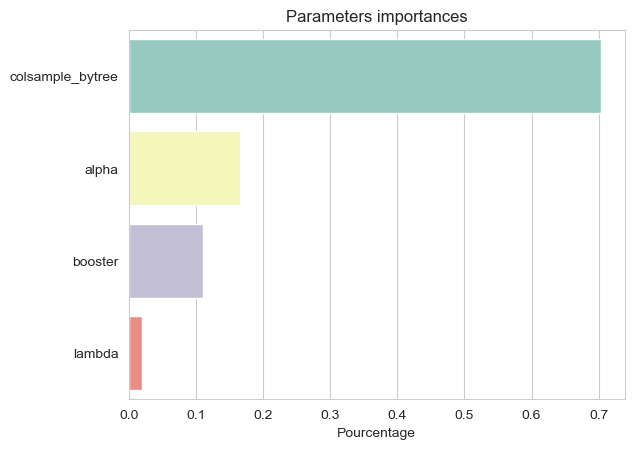

In [14]:
# display importances 
perc =  [float(i) for i in history['Importances'].values()]
sns.barplot(x=perc,y=list(history['Importances'].keys()))
plt.title("Parameters importances")
plt.xlabel("Pourcentage")
plt.show()

In [15]:
accuracy_global = history["Best trial accuracy"]
accuracy_global

0.685982478097622

In [16]:
# then test for each player at  a time
history_per_player = []

for player in PLAYERS:
    history_per_player.append(for_player(player))

[I 2024-08-23 16:07:07,983] A new study created in memory with name: no-name-fa3b4a4e-9323-4b86-ba9c-a9a26a7f0ba7
[I 2024-08-23 16:07:08,326] Trial 0 finished with value: 0.7067775116246301 and parameters: {'booster': 'gbtree', 'lambda': 0.0027457328208421268, 'alpha': 6.548611989882464e-06, 'colsample_bytree': 0.8194223005965187, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.1048141712410268, 'gamma': 0.14210345446212913}. Best is trial 0 with value: 0.7067775116246301.
[I 2024-08-23 16:07:08,495] Trial 1 finished with value: 0.5536142031844441 and parameters: {'booster': 'gbtree', 'lambda': 0.03039838667608065, 'alpha': 8.94819233570603e-09, 'colsample_bytree': 0.7125052192545266, 'max_depth': 5, 'min_child_weight': 10, 'eta': 3.064994651039008e-05, 'gamma': 0.13152316487329396}. Best is trial 0 with value: 0.7067775116246301.
[I 2024-08-23 16:07:08,753] Trial 2 finished with value: 0.5626320980696069 and parameters: {'booster': 'gbtree', 'lambda': 3.730847318840159e-07, 'alpha': 0

In [17]:
df_hist = pd.DataFrame.from_dict(history_per_player)
mean_accuracy_per_player = df_hist['Best trial accuracy'].mean()
mean_accuracy_per_player
## le résultat est meilleur lorsqu'on prend tous les joueurs

0.6847148595221675

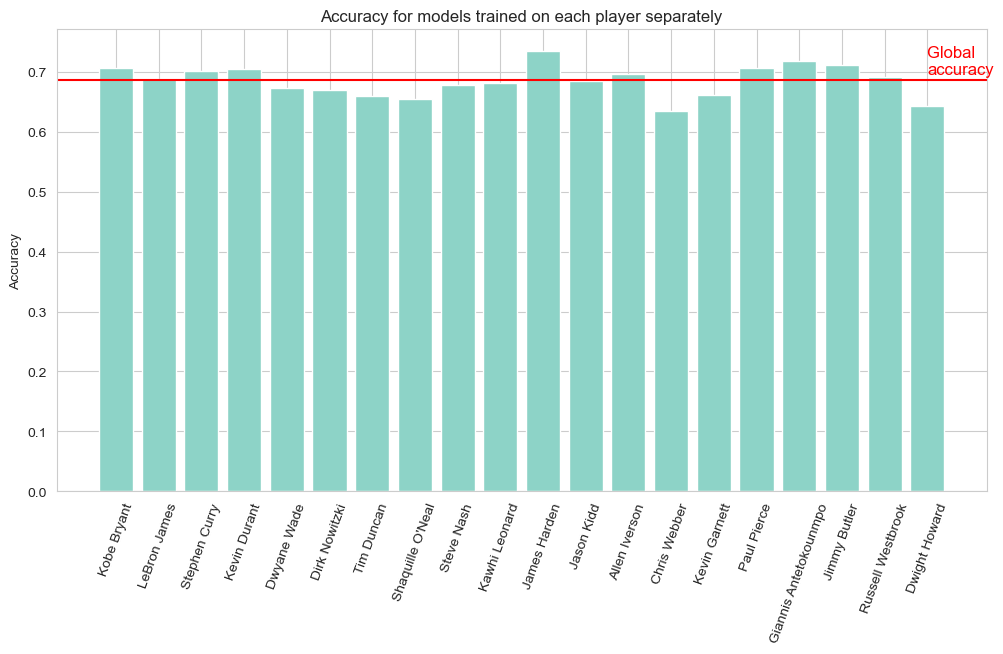

In [43]:
plt.figure(figsize=(12,6))
plt.bar(df_hist.Player, df_hist['Best trial accuracy'])
plt.xticks(rotation=70)
plt.axhline(y=accuracy_global, color='r')
plt.text(19 ,accuracy_global + 0.01, "Global \naccuracy" , {'color':'r', 'fontsize':'12'})
plt.title("Accuracy for models trained on each player separately")
plt.ylabel("Accuracy")
plt.show()

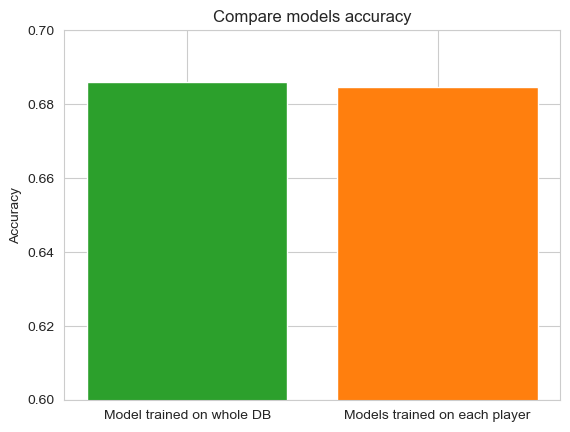

In [41]:
plt.bar(['Model trained on whole DB', 'Models trained on each player'], [accuracy_global, mean_accuracy_per_player], color=['tab:green', 'tab:orange'])
plt.ylim([0.6,0.7])
plt.ylabel("Accuracy")
plt.title("Compare models accuracy")
plt.show()

In [42]:
# Les résultats sont équivalents (~0.684). Le modèle entrainé sur tout le dataset est légèrement meilleur.